In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow import expand_dims
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.applications.xception import Xception, preprocess_input

from tensorflow.keras.models import Model

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import cv2
import os

print(os.listdir('../input'))
# Any results you write to the current directory are saved as output.

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

['xception', 'resnet50', 'model-weights', 'stanford-dogs-dataset-traintest']


In [2]:
TRAIN_DIR = '../input/stanford-dogs-dataset-traintest/cropped/cropped/train'
TEST_DIR = '../input/stanford-dogs-dataset-traintest/cropped/cropped/test'

In [3]:
BREED_NAME = sorted([breed for breed in os.listdir(TRAIN_DIR)])
BREED_CODE = [breed.split('-')[0] for breed in os.listdir(TRAIN_DIR)]
BREED_ENCODE = {v:k for v, k in enumerate(BREED_NAME)}
NUM_CLASSES = len(BREED_NAME)


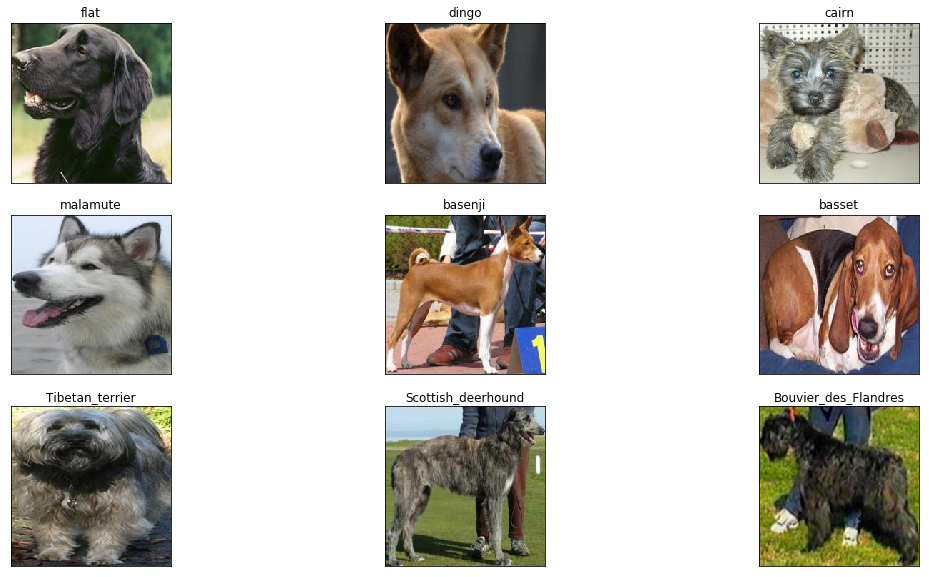

In [4]:
def show_image(num_images=9):
    plt.figure(figsize=(19, 10))
    count = 1
    for i in range(num_images):
        
        breed_dir = np.random.choice([dirct for dirct in os.listdir(TRAIN_DIR)])
        img_dir = np.random.choice([img for img in os.listdir(TRAIN_DIR+'/'+breed_dir)])
        img = cv2.imread(TRAIN_DIR+'/'+breed_dir+'/'+img_dir)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, count)
        plt.imshow(img)
        plt.title('{}'.format(breed_dir.split('-')[1]))
        plt.xticks([])
        plt.yticks([])
        count+=1
    plt.show()
        
        
show_image()

    

In [5]:
datagen = ImageDataGenerator( 
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    rotation_range=40,
    zoom_range = 0.1,
    rescale=1./255,
    validation_split=0.33)

train_gen = datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42, 
    subset="training"           
    )

valid_gen = datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42, 
    subset="validation"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 8040 images belonging to 120 classes.
Found 3960 images belonging to 120 classes.
Found 8580 images belonging to 120 classes.


In [6]:
weights = '../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model = Xception(weights=weights, include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

for layer in base_model.layers:
    layer.trainable = False

xception = Model(inputs=base_model.input, outputs=predictions)

xception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [7]:
from tensorflow.keras.optimizers import RMSprop
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

In [8]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

file_path = 'model_weights.hdf5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [9]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

In [10]:
xception.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = xception.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    verbose=1,
                    callbacks=[checkpoint, learning_rate_reduction])

Epoch 1/10
124/125 [============================>.] - ETA: 0s - loss: 2.8480 - acc: 0.3814
Epoch 00001: val_acc improved from -inf to 0.70466, saving model to model_weights.hdf5
125/125 [==============================] - 163s 1s/step - loss: 2.8408 - acc: 0.3826 - val_loss: 1.0693 - val_acc: 0.7047
Epoch 2/10
124/125 [============================>.] - ETA: 0s - loss: 1.6172 - acc: 0.5774
Epoch 00002: val_acc improved from 0.70466 to 0.72772, saving model to model_weights.hdf5
125/125 [==============================] - 140s 1s/step - loss: 1.6148 - acc: 0.5774 - val_loss: 1.1070 - val_acc: 0.7277
Epoch 3/10
124/125 [============================>.] - ETA: 0s - loss: 1.4143 - acc: 0.6289
Epoch 00003: val_acc improved from 0.72772 to 0.73130, saving model to model_weights.hdf5
125/125 [==============================] - 139s 1s/step - loss: 1.4147 - acc: 0.6286 - val_loss: 1.1391 - val_acc: 0.7313
Epoch 4/10
124/125 [============================>.] - ETA: 0s - loss: 1.2562 - acc: 0.6527
Epo

In [12]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
loss, acc = xception.evaluate_generator(generator=test_generator, steps=STEP_SIZE_TEST, verbose=0)
print(loss, acc)


0.7365152887533414 0.8488806


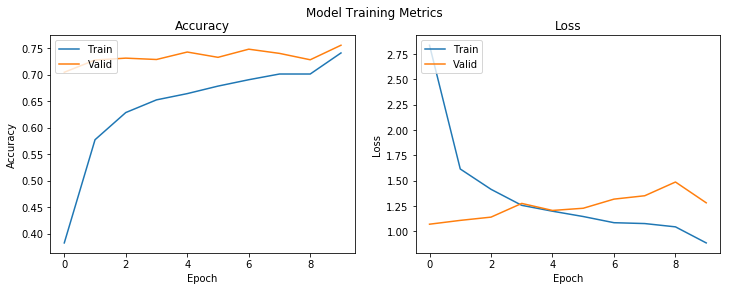

In [13]:
def plot_model_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Model Training Metrics')

    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.title.set_text('Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Valid'], loc='upper left')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.title.set_text('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Valid'], loc='upper left')

    fig.show()
    
    
plot_model_history(history)

In [14]:
def decode_prediction(preds, top=3):
    top_indices = preds.argsort()[-top:][::-1]
    result = [(BREED_ENCODE[i], preds[i]) for i in top_indices] # (labels, scores)
    result.sort(key=lambda x: x[1], reverse=True)
    return '\n'.join(['{}: {:.4f}'.format(*item) for item in result])




In [15]:
def preprocess_image(file_path):
    
    img = image.load_img(file_path)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    return img, x





In [16]:
def inference(image, model, decode=False):
    preds = model.predict(image)[0]
    if decode:
        result = decode_prediction(preds)
        return result
    return preds

In [17]:
def show_pred_image(num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(20, 16))
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        
        breed_dir = np.random.choice([dirct for dirct in os.listdir(TRAIN_DIR)])
        img_dir = np.random.choice([img for img in os.listdir(TRAIN_DIR+'/'+breed_dir)])
        img, prep_img = preprocess_image(TRAIN_DIR+'/'+breed_dir+'/'+img_dir)
        #img = cv2.imread(TRAIN_DIR+'/'+breed_dir+'/'+img_dir)
        #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        result = inference(prep_img, xception, decode=True)
      
        ax.imshow(img)
        ax.set_title(result)
        ax.set_xlabel('{}'.format(breed_dir.split('-')[1]))
        ax.grid(False)
        
       
    plt.tight_layout()

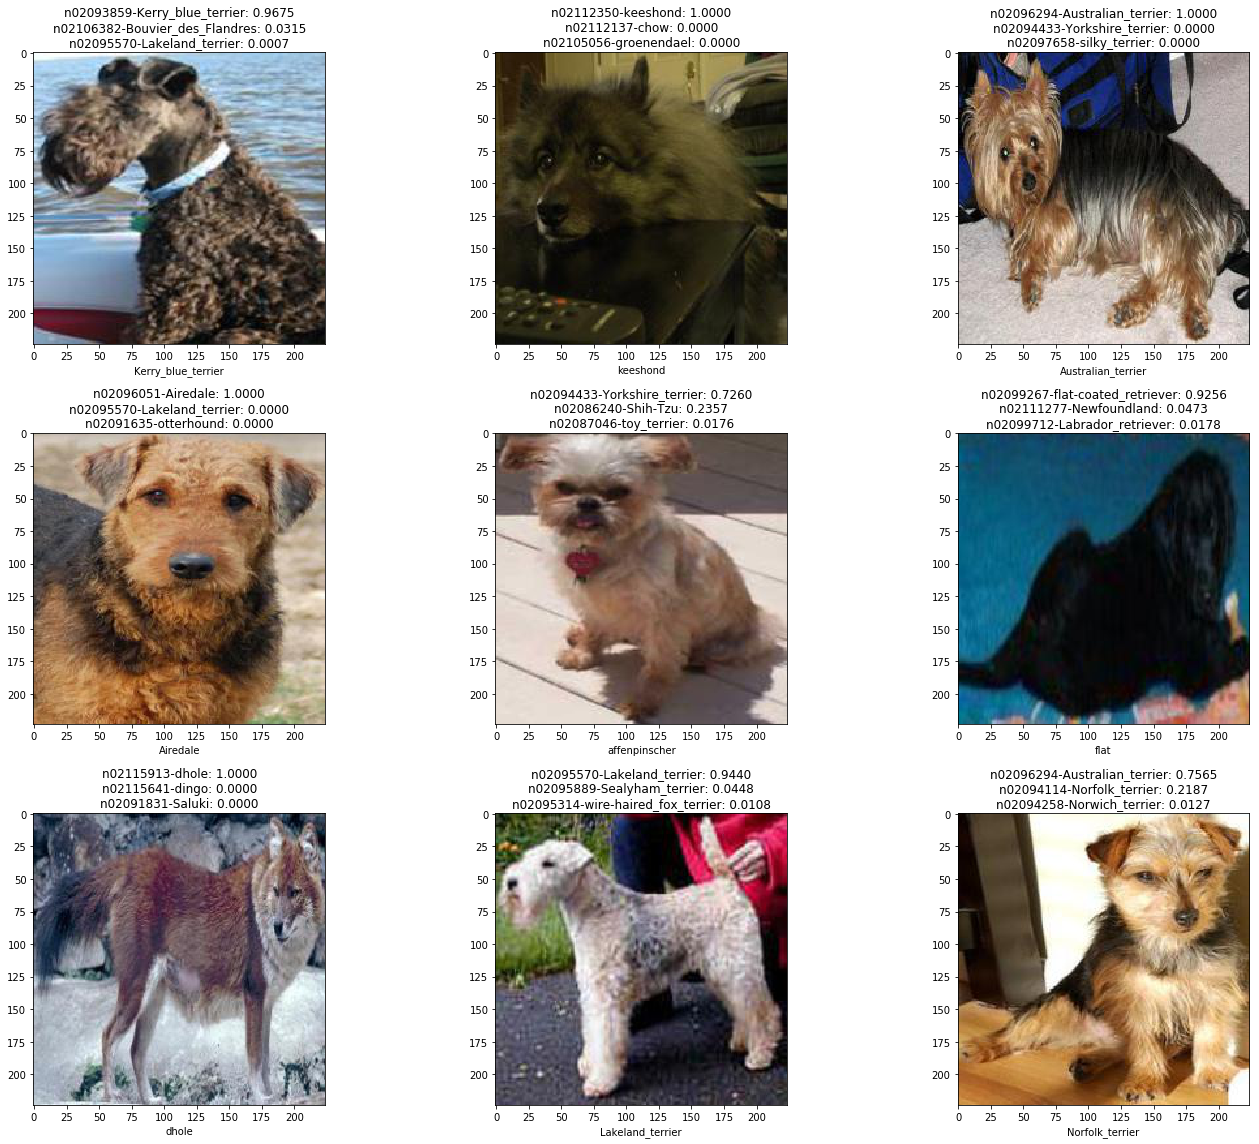

In [18]:
show_pred_image()

In [19]:
xception_json = xception.to_json()
model_json = 'model.json'
with open(model_json, "w") as json_file:
        json_file.write(xception_json)


In [20]:
import json
json = json.dumps(BREED_ENCODE)
f = open("labels.json","w")
f.write(json)
f.close()